# Data Downtime Challenge | Exercise 4

## 0. Setup

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [3]:
from ex4_utils import all_days, show_reports, VALID_OUTAGE_DATES, show_threshold_plot, show_f_plots

In [4]:
import sqlite3

conn = sqlite3.connect('Ex4.db')
c = conn.cursor()

## 1. Introduction

In the last exercise, we moved one step closer towards algorithms for generic data downtime issues. We now have all the tools we need for data downtime in our small sandbox environment.

The question is, will it scale? Notice that the algorithms we've developed are specially tuned to a small number of tables. In practice, good data downtime algorithms should handle a large number of tables at high volume. To do this, we need to invoke some terms from statistics and machine learning.

## 2. Precision & Recall

Whenever we alert a user about a data downtime issue, we have to question whether the alert was accurate. Does the alert indicate a _genuine_ problem? We might be worried about two scenarios:
1. An alert was issued, but there was no genuine issue. We've wasted the user's time responding to the alert.
2. There was a genuine issue, but no alert was issued. We've let a performance issue go undetected.

These two scenarios are best to think about as **false positives** (predicted anomalous, actually OK) and **false negatives** (predicted OK, actually anomalous). We also have **true positives** and **true negatives**:

|   | Predicted Anomalous  | Predicted OK  |
|---|---|---|
| **Actually Anomalous** | True Positive (TP) | False Negative (FN) |
| **Actually OK** | False Positive (FP) | True Negative (FN) |

We want a good detection scheme to minimize both False Positives and False Negatives. In practice, it's more helpful to think about related terms, **precision** and **recall**:

$$\text{Precision} = \frac{TP}{TP + FP} = \frac{\text{Correct anomalous predictions}}{\text{All anomalous predictions}}$$

$$\text{Recall} = \frac{TP}{TP + FN} = \frac{\text{Correct anomalous predictions}}{\text{All actual anomalies}}$$

Precision, generally, tells us how often we're right when we issue an alert. Recall, generally, tells us how many issue we actually alert for.

### Balancing Precision and Recall
Notice that there's an explicit tradeoff between these two. How do we get perfect precision? Simple: alert for _nothing_, forcing us to have a False Positive rate of 0%. The problem? Recall will be horrible, since our False Negative rate will be huge.

Likewise, how do we get perfect recall? Also simple: alert for _everything_, forcing a False Negative rate of 0%. The issue, as expected, is that our False Positive rate will suffer, affecting precision.

### Solution: A Singular Objective

In many cases we'll want a singular objective to optimize, not two. We can combine both precision and recall into a single metric called an $F$-score:

$$F_\beta = (1+\beta^2)\cdot\frac{precision \cdot recall}{\beta^2precision + recall}$$

$F_\beta$ is called a **weighted $F$-score**, since different values for $\beta$ weigh precision and recall. When $\beta = 1$, the equation values each equally. Set $\beta > 1$, and recall will be more important for a higher score. In other words, $\beta > 1$ says, "I care more about catching all anomalies than occasionally causing a false alarm." Likewise, set $\beta < 1$, and precision will be more important. $\beta < 1$ says, "I care more about my alarms being genuine than catching every real issue."

## 3. Exercise: Balancing Precision and Recall

Here's a simple exercise: let's look at **freshness** with the `EXOPLANETS` table again. We have new data, and while the data continues to enter at a normally daily cadence, we have occasional outages. A key question: how many days without data is enough to issue an alert? A day without new data may be fine, but two weeks is obviously a problem. In the middle, there's a grey area. Could three days be considered anomalous? Four? Five?

Your code for this exercise is simple: set a hyperparameter! The smaller `THRESHOLD_DAYS` is, the more alerts will be issued. Rerun with different parameters to see how precision, recall, and $F_1$-score are affected.

In [5]:
# YOUR CODE HERE
THRESHOLD_DAYS = 2
# END YOUR CODE

In [6]:
SQL = """
SELECT
    DATE_ADDED,
    COUNT(*) AS ROWS_ADDED
FROM
    EXOPLANETS
GROUP BY
    DATE_ADDED
"""

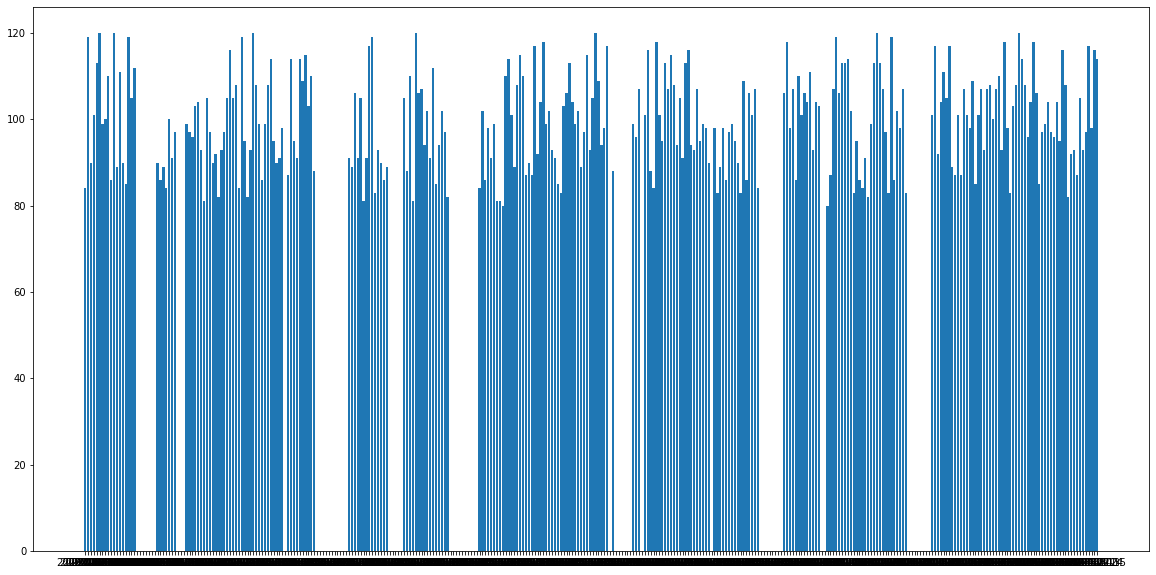

In [7]:
rows_added = pd.read_sql_query(SQL, conn)
rows_added = rows_added \
    .rename(columns={clmn: clmn.lower() for clmn in rows_added.columns})
rows_added = rows_added.set_index("date_added")
rows_added = rows_added.reindex(all_days)
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=rows_added["rows_added"])
plt.show()

In [8]:
SQL = """
WITH RC_UPDATES AS(
    SELECT
        DATE_ADDED,
        COUNT(*) AS ROWS_ADDED
    FROM
        EXOPLANETS
    GROUP BY
        DATE_ADDED
),
NUM_DAYS_UPDATES AS(
    SELECT
        DATE_ADDED,
        JULIANDAY(DATE_ADDED) - JULIANDAY(LAG(DATE_ADDED) OVER(ORDER BY DATE_ADDED)) AS DAYS_SINCE_UPDATE
    FROM
        RC_UPDATES
)
SELECT
    *
FROM
    NUM_DAYS_UPDATES
WHERE
    DAYS_SINCE_UPDATE > {}
""".format(THRESHOLD_DAYS)

In [9]:
freshness_anoms = pd.read_sql_query(SQL, conn)
freshness_anoms = freshness_anoms \
    .rename(columns={clmn: clmn.lower() for clmn in freshness_anoms.columns})
freshness_anoms

,date_added,days_since_update
0,2020-01-26,8.0
1,2020-02-05,4.0
2,2020-04-01,12.0
3,2020-04-20,6.0
4,2020-05-16,11.0
5,2020-07-08,7.0
6,2020-08-29,9.0
7,2020-09-13,3.0
8,2020-10-19,9.0
9,2021-01-05,8.0


The `show_reports` function from `utils` will help us visualize our results.

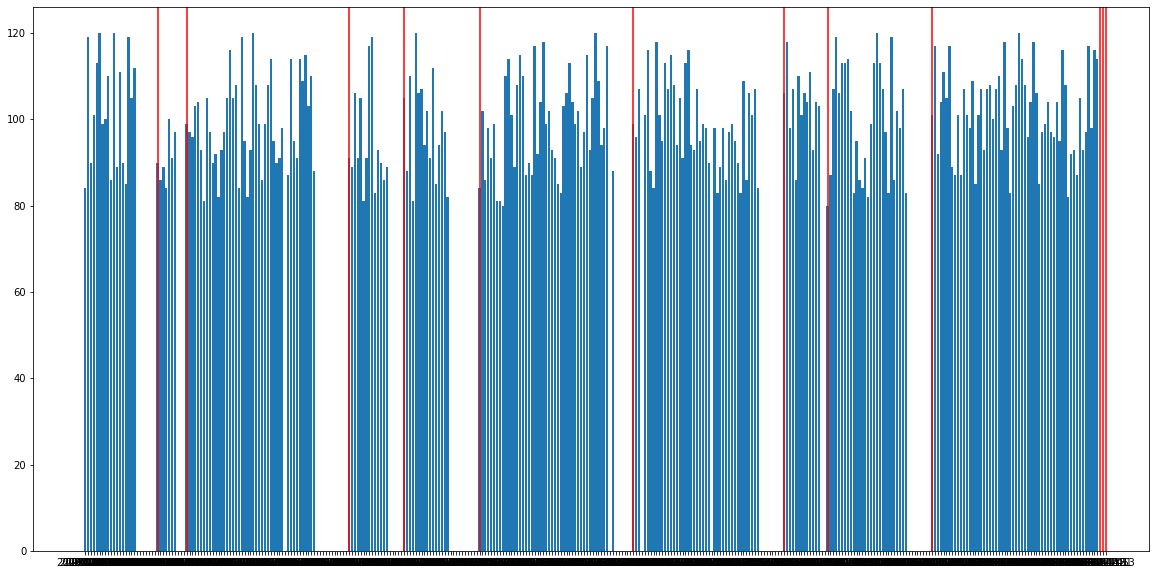

In [10]:
show_reports(rows_added, freshness_anoms["date_added"], "rows_added")

We have another table called `EXOPLANET_OUTAGES`, which serves as our "ground truth" for this exercise. If a date is in `EXOPLANET_OUTAGES`, then we consider an alert on that date to be genuine. In practice, such a table wouldn't be available, but it's helpful here for illustrating the relationship between precision and recall.

#TODO

In [11]:
TP = len(set(freshness_anoms["date_added"]).intersection(VALID_OUTAGE_DATES))
FP = len(set(freshness_anoms["date_added"]).difference(VALID_OUTAGE_DATES))
FN = len(VALID_OUTAGE_DATES.difference(set(freshness_anoms["date_added"])))

In [12]:
print("Precision: {}".format(TP / (TP + FP)))
print("Recall:    {}".format(TP / (TP + FN)))

Precision: 0.6666666666666666
Recall:    0.8888888888888888


You might notice that setting `THRESHOLD_DAYS` to different values illustrates the explicit tradeoff between precision and recall. In the plot below, we can visualize this tradeoff as we run `THRESHOLD_DAYS` through values from 0 to 14:

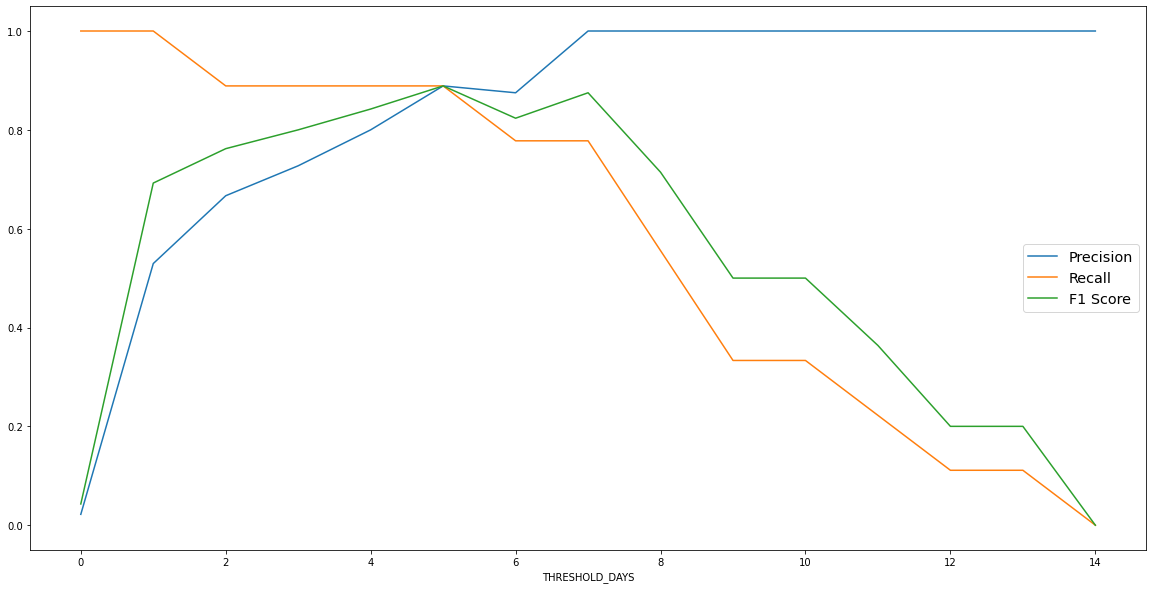

In [13]:
show_threshold_plot(conn)

As expected, setting `THRESHOLD_DAYS = 0` (alerting for _everything_) results in perfect recall, but terrible precision. Setting `THRESHOLD_DAYS = 14` (the length of the longest outage, thus alerting for _nothing_) results in the inverse -- perfect precision, but zero recall.

The $F_1$ score, which balances precision and recall equally, tells us that our sweet spot is somewhere around `THRESHOLD_DAYS = 5`. Note however that other values for $\beta$ result in $F_\beta$ scores that change our optimal threshold value:

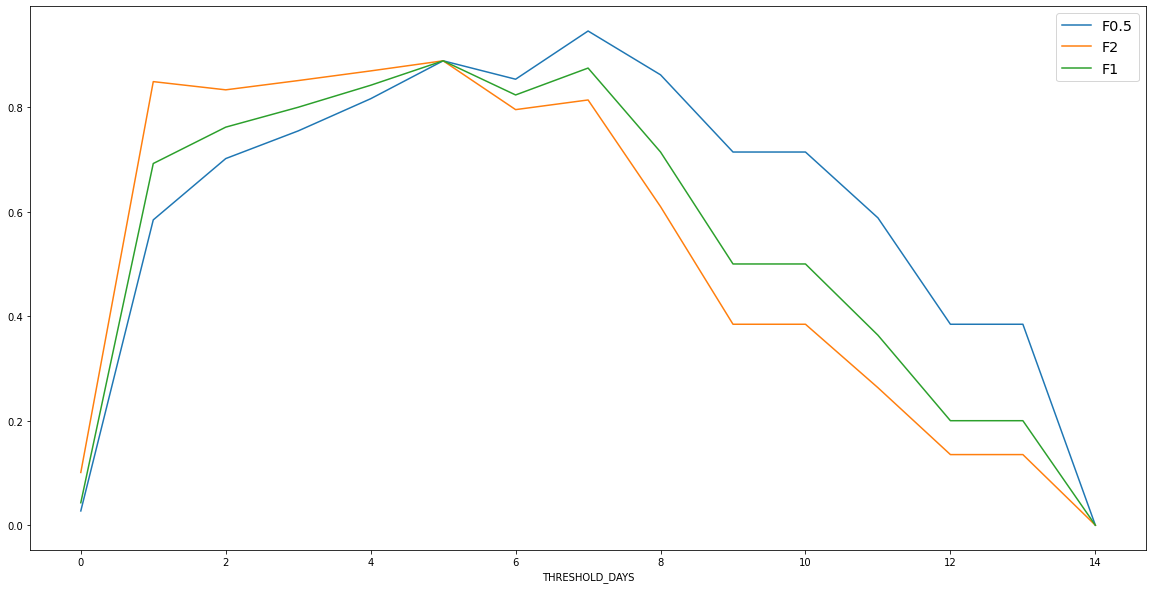

In [14]:
show_f_plots(conn)

Since $F_2$ prioritizes recall, it prefers lower values `THRESHOLD_DAYS`, making for a more "aggressive" detector. $F_{0.5}$ instead prioritizes precision, preferring higher values for `THRESHOLD_DAYS` and thus a more "conservative" detector.

# Great work!

Terms like true/false positives, precision, recall, and f-scores are essential vocabulary for scaling a data downtime solution, since each particular use case has unique challenges. We hope you benefitted from this quick primer on these topics!